In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

import multiprocessing

#### Base Simulation

In [2]:
def parallel_code(thread, time_steps, voltages, network_topology, topology_parameter,  np_info, folder):

    for rem_d in np.arange(1,21,1):

        nanonets_utils.memory_capacity_simulation(time_steps, voltages, train_length=5000, test_length=5000, remember_distance=rem_d, folder=folder, np_info=np_info,
                                                network_topology=network_topology, topology_parameter=topology_parameter, save_th=0.1, path_info=f'_{thread}')

#### Input Voltage

Number of Steps: 50000


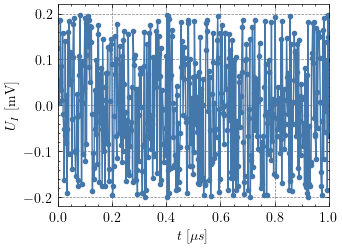

In [3]:
# Define Time Scale
step_size   = 2e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)

print(f"Number of Steps: {N_steps}")

input_volt = np.random.uniform(-0.2,0.2,N_steps)

# Voltage Array
voltages        = np.zeros((N_steps, 9))
voltages        = np.zeros((N_steps, 9))
voltages[:,0]   = input_volt

# Plot
with plt.style.context(["science","bright","grid"]):
    
    plt.plot(time_steps*10**6, input_volt, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [mV]")
    plt.xlim(0,1)
    plt.show()

#### Init Network

In [37]:
# Network Style
network_topology = "cubic"

topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

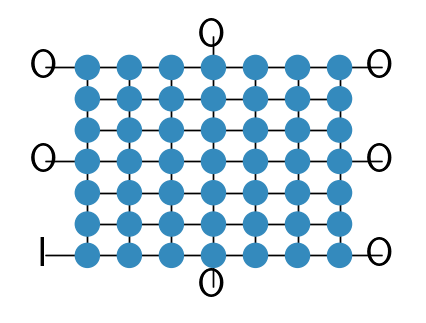

In [38]:
fig, ax = nanonets_utils.display_network(np_network_sim, provide_electrode_labels=['I','O','O','O','O','O','O','O'],
                                         font_size=30, save_to_path='plots/network.pdf', width_scale=1.5, height_scale=1.5)

#### Lattice without Disorder

In [6]:
N_processes = 10
folder      = "data/lattice_without_disorder/"

for i in range(N_processes):

    process = multiprocessing.Process(target=parallel_code, args=(i,time_steps,voltages,network_topology,topology_parameter,None,folder))
    process.start()

#### Load Data

In [30]:
mc_mean = []
mc_stds = []

for rem_d in np.arange(1,21,1):

    values = []
    
    for i in range(10):

        df  = pd.read_csv(f"{folder}mc_test_results_{rem_d}_{i}.csv", index_col=0)

        values.append(df.corr().loc['y_pred','y_test'])

    mc_mean.append(np.mean(values))
    mc_stds.append(np.std(values)/np.sqrt(10))

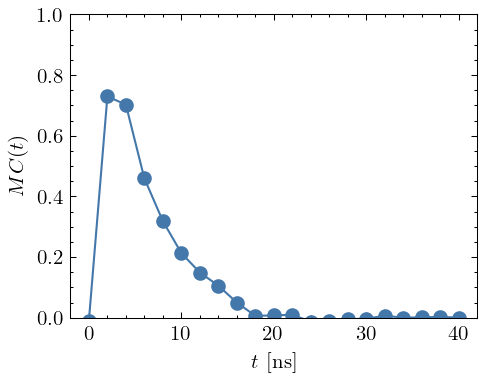

In [31]:
xvals = np.arange(1,21,1)*step_size*10**9

with plt.style.context(["science","bright"]):

    plt.figure(dpi=150)
    plt.errorbar(xvals, mc_mean, mc_stds, marker='o')
    plt.xlabel("$t$ [ns]")
    plt.ylabel("$MC(t)$")
    plt.ylim(0,1)
    plt.show()

#### Lattice with Disorder

In [32]:
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 2.0,
    "np_distance"   : 1.0
}

In [33]:
N_processes = 10
folder      = "data/lattice_C_disorder/"

for i in range(N_processes):

    process = multiprocessing.Process(target=parallel_code, args=(i,time_steps,voltages,network_topology,topology_parameter,np_info,folder))
    process.start()

In [35]:
mc_mean = []
mc_stds = []

for rem_d in np.arange(1,21,1):

    values = []
    
    for i in range(10):

        df  = pd.read_csv(f"{folder}mc_test_results_{rem_d}_{i}.csv", index_col=0)

        values.append(df.corr().loc['y_pred','y_test'])

    mc_mean.append(np.mean(values))
    mc_stds.append(np.std(values)/np.sqrt(10))

ValueError: 'x' and 'y' must have the same size

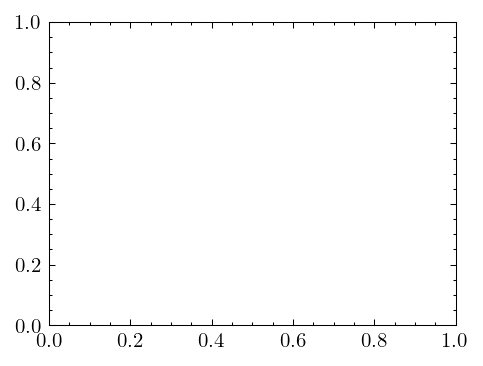

In [39]:
xvals = np.arange(1,21,1)*step_size*10**9

with plt.style.context(["science","bright"]):

    plt.figure(dpi=150)
    plt.errorbar(xvals, mc_mean, mc_stds, marker='o')
    plt.xlabel("$t$ [ns]")
    plt.ylabel("$MC(t)$")
    plt.ylim(0,1)
    plt.show()